In [1]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from utils import imshow, image_folder_custom_label

In [2]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [4]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 

])

In [5]:
imagnet_data = image_folder_custom_label(root='./data/imagenet', transform=transform, idx2label=idx2label)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)

True Image & True Label


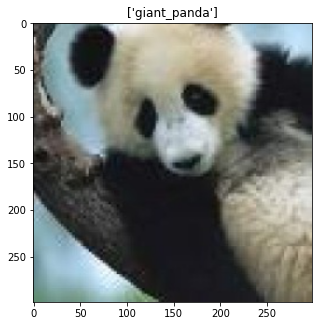

In [6]:
images, labels = iter(data_loader).next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [imagnet_data.classes[i] for i in labels])

In [7]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [8]:
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    models.resnet18(pretrained=True)
).to(device)

model = model.eval()

In [9]:
from collections import OrderedDict
from collections.abc import Iterable

def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get('_attacks').values():
            eval("atk."+func.__name__+"(*args, **kwargs)")
        return result
    return wrapper_func

class Attack(object):

    def __init__(self, name, model):


        self.attack = name
        self._attacks = OrderedDict()
        
        self.set_model(model)
        self.device = next(model.parameters()).device

        self.attack_mode = 'default'
        self.supported_mode = ['default']
        self.targeted = False
        self._target_map_function = None

        self.normalization_used = None
        self._normalization_applied = None
        self._set_auto_normalization_used(model)

        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):

        raise NotImplementedError
        
    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = str(model).split("(")[0]

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag
    
    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_auto_normalization_used(self, model):
        mean = getattr(model, 'mean', None)
        std = getattr(model, 'std', None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used['mean'] = mean
        self.normalization_used['std'] = std
        self._normalization_applied = True

    def normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return inputs*std + mean

    def get_mode(self):

        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):

        self.attack_mode = 'default'
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        print("Attack mode is changed to '%s'."%mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function):

        self._set_mode_targeted('targeted(custom)')
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self):

        self._set_mode_targeted('targeted(random)')
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1):
 
        self._set_mode_targeted('targeted(least-likely)')
        assert (kth_min > 0)
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_model_training_mode(self, model_training=False, batchnorm_training=False, dropout_training=False):

        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if 'BatchNorm' in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if 'Dropout' in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(self, data_loader, save_path=None, verbose=True, return_verbose=False,
             save_predictions=False, save_clean_inputs=False, save_type='float'):

        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = (pred == labels.to(self.device))
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    
                    delta = (adv_inputs - inputs.to(self.device)).view(batch_size, -1)
                    l2_distance.append(torch.norm(delta[~right_idx], p=2, dim=1))
                    l2 = torch.cat(l2_distance).mean().item()

                    
                    progress = (step+1)/total_batch*100
                    end = time.time()
                    elapsed_time = end-start

                    if verbose:
                        self._save_print(progress, rob_acc, l2, elapsed_time, end='\r')

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)
                
                save_dict = {'adv_inputs':adv_input_list_cat, 'labels':label_list_cat}

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict['preds'] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict['clean_inputs'] = input_list_cat
                    
                if self.normalization_used is not None:
                    save_dict['adv_inputs'] = self.inverse_normalize(save_dict['adv_inputs'])
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.inverse_normalize(save_dict['clean_inputs'])

                if save_type == 'int':
                    save_dict['adv_inputs'] = self.to_type(save_dict['adv_inputs'], 'int')
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.to_type(save_dict['clean_inputs'], 'int')

                save_dict['save_type'] = save_type
                torch.save(save_dict, save_path)

        
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end='\n')

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        
        if type == 'int':
            if isinstance(inputs, torch.FloatTensor) or isinstance(inputs, torch.cuda.FloatTensor):
                return (inputs*255).type(torch.uint8)
        elif type == 'float':
            if isinstance(inputs, torch.ByteTensor) or isinstance(inputs, torch.cuda.ByteTensor):
                return inputs.float()/255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print('- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t' \
              % (progress, rob_acc, l2, elapsed_time), end=end)

    @staticmethod
    def load(load_path, batch_size=128, shuffle=False, normalize=None,
             load_predictions=False, load_clean_inputs=False):
        save_dict = torch.load(load_path)
        keys = ['adv_inputs', 'labels']

        if load_predictions:
            keys.append('preds')
        if load_clean_inputs:
            keys.append('clean_inputs')

        if save_dict['save_type'] == 'int':
            save_dict['adv_inputs'] = save_dict['adv_inputs'].float()/255
            if load_clean_inputs:
                save_dict['clean_inputs'] = save_dict['clean_inputs'].float()/255
                
        if normalize is not None:
            n_channels = len(normalize['mean'])
            mean = torch.tensor(normalize['mean']).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize['std']).reshape(1, n_channels, 1, 1)
            save_dict['adv_inputs'] = (save_dict['adv_inputs'] - mean) / std
            if load_clean_inputs:
                save_dict['clean_inputs'] = (save_dict['clean_inputs'] - mean) / std

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print("Data is loaded in the following order: [%s]"%(", ".join(keys)))
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):

        if self._target_map_function is None:
            raise ValueError('target_map_function is not initialized by set_mode_targeted.')
        target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l)*torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ['model', 'attack', 'supported_mode']

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info['attack_mode'] = self.attack_mode
        info['normalization_used'] = True if self.normalization_used is not None else False

        return self.attack + "(" + ', '.join('{}={}'.format(key, val) for key, val in info.items()) + ")"

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)
        
        attacks = self.__dict__.get('_attacks')

        
        def get_all_values(items, stack=[]):
            if (items not in stack):
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = (list(items.keys())+list(items.values()))
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items
                
        for num, value in enumerate(get_all_values(value)):
            attacks[name+"."+str(num)] = value
            for subname, subvalue in value.__dict__.get('_attacks').items():
                attacks[name+"."+subname] = subvalue

In [10]:
class FGSM(Attack):

    def __init__(self, model, eps=8/255):
        super().__init__("FGSM", model)
        self.eps = eps
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        outputs = self.get_logits(images)

        
        if self.targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        
        grad = torch.autograd.grad(cost, images,
                                   retain_graph=False, create_graph=False)[0]

        adv_images = images + self.eps*grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

In [11]:
atk1 = FGSM(model, eps=0.007)

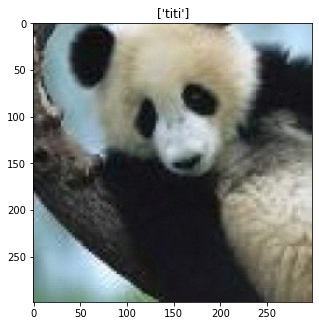

In [12]:
adv_images1 = atk1(images, labels)
labels = labels.to(device)
outputs1 = model(adv_images1)

_, pre = torch.max(outputs1.data, 1)



imshow(torchvision.utils.make_grid(adv_images1.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


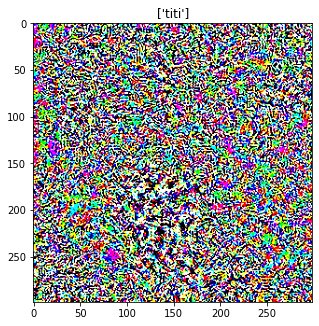

In [13]:

pert1 = adv_images1 - images


imshow(torchvision.utils.make_grid(pert1.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


In [14]:
class BIM(Attack):

    def __init__(self, model, eps=8/255, alpha=2/255, steps=10):
        super().__init__("BIM", model)
        self.eps = eps
        self.alpha = alpha
        if steps == 0:
            self.steps = int(min(eps*255 + 4, 1.25*eps*255))
        else:
            self.steps = steps
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
  
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        ori_images = images.clone().detach()

        for _ in range(self.steps):
            images.requires_grad = True
            outputs = self.get_logits(images)

            
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

           
            grad = torch.autograd.grad(cost, images,
                                       retain_graph=False,
                                       create_graph=False)[0]

            adv_images = images + self.alpha*grad.sign()
            a = torch.clamp(ori_images - self.eps, min=0)
            b = (adv_images >= a).float()*adv_images \
                + (adv_images < a).float()*a
            c = (b > ori_images+self.eps).float()*(ori_images+self.eps) \
                + (b <= ori_images + self.eps).float()*b
            images = torch.clamp(c, max=1).detach()

        return images

In [15]:
atk2 = BIM(model, eps=8/255, alpha=2/255, steps=10)

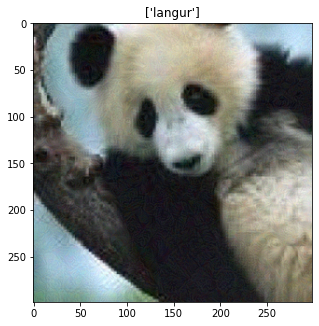

In [16]:
adv_images2 = atk2(images, labels)
labels = labels.to(device)
output2 = model(adv_images2)

_, pre = torch.max(output2.data, 1)



imshow(torchvision.utils.make_grid(adv_images2.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


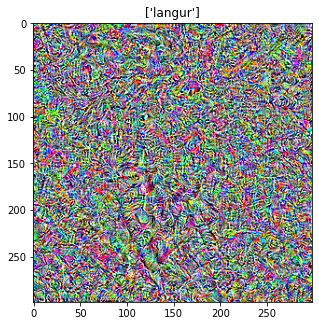

In [17]:

pert2 = adv_images2 - images


imshow(torchvision.utils.make_grid(pert2.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


In [18]:
class RFGSM(Attack):

    def __init__(self, model, eps=8/255, alpha=2/255, steps=10):
        super().__init__("RFGSM", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
       
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        adv_images = images + self.alpha*torch.randn_like(images).sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]
            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images


In [19]:
atk3 = RFGSM(model, eps=8/255, alpha=2/255, steps=10)

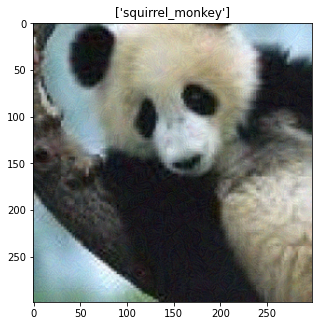

In [20]:
adv_images3 = atk3(images, labels)
labels = labels.to(device)
output3 = model(adv_images3)

_, pre = torch.max(output3.data, 1)



imshow(torchvision.utils.make_grid(adv_images3.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])


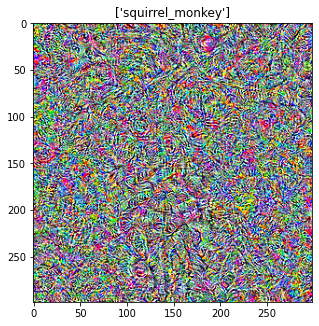

In [21]:

pert3 = adv_images3 - images


imshow(torchvision.utils.make_grid(pert3.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])
